In [7]:
import os.path as op
import os
# import sys
import numpy as np
import pandas as pd
import mne


In [11]:
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
file_name = 'mg99a01'
raw_fname_in = op.join(data_path, file_name + '.fif')
raw = mne.io.read_raw_fif(
    raw_fname_in,
    allow_maxshield=True,
    preload=False,
    verbose=True)

Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_24652\3183654472.py:3: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.


In [12]:
from mne.preprocessing import find_bad_channels_maxwell
import matplotlib.pyplot as plt
# Detect bad channels
raw.info['bads'] = []
raw_check = raw.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=None, 
            calibration=None,
            return_scores=True,
            verbose=True)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 874999  =      0.000 ...   874.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Scanning for bad channels in 175 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.7s finished


    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG2641
        Interval   8:   35.000 -   39.999
            Flat ( 2): MEG1241 MEG2641
        Interval   9:   40.000 -   44.999
            Flat ( 2): MEG1241 MEG2641
        Interval  10:   45.000 -   49.999
            Flat ( 2): MEG1241 MEG2641
        I

In [13]:
print('noisy =', auto_noisy_chs)
print('flat = ', auto_flat_chs)
raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
print('bads =', raw.info['bads'])

noisy = ['MEG0413']
flat =  ['MEG1241', 'MEG2641']


In [16]:
# Visualize the scoring used to classify channels as noisy or flat
import seaborn as sns
def viz_badch_scores(auto_scores, ch_type):
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    fig.suptitle(f'Automated noisy/flat channel detection: {ch_type}',
                  fontsize=16, fontweight='bold')
    
    #### Noisy channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_noisy'][ch_subset]
    limits = auto_scores['limits_noisy'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[0].set_title('Noisy: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmin=np.nanmin(limits),
                cmap='Reds', 
                cbar=True, 
                # cbar_kws=dict(label='Score'), 
                ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[1].set_title('Noisy: Scores > Limit', fontweight='bold')
    
    #### Flat channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_flat'][ch_subset]
    limits = auto_scores['limits_flat'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[2])
    [ax[2].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[2].set_title('Flat: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmax=np.nanmax(limits),
                cmap='Reds', 
                cbar=True,
                # cbar_kws=dict(label='Score'), 
                ax=ax[3])
    [ax[3].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[3].set_title('Flat: Scores > Limit', fontweight='bold')
    
    # Fit figure title to not overlap with the subplots
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

ch_type = 'grad'
fig = viz_badch_scores(auto_scores, ch_type)


ImportError: cannot import name 'seaborn' from 'matplotlib' (d:\projects\WM_GRID\venv\lib\site-packages\matplotlib\__init__.py)

In [17]:
# Fix Elekta magnetometer coil types
raw.fix_mag_coil_types()

102 of 102 magnetometer types replaced with T3.


<Raw | mg99a01.fif, 310 x 875000 (875.0 s), ~6.5 MB, data not loaded>

In [18]:
raw_sss = mne.preprocessing.maxwell_filter(
    raw,
    cross_talk=None,
    calibration=None,
    st_duration=None,
    #coord_frame="meg", #only for empy room, comment it if using HPI
    verbose=True)

Maxwell filtering raw data
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Loading raw data from disk
    Processing 87 data chunks
[done]


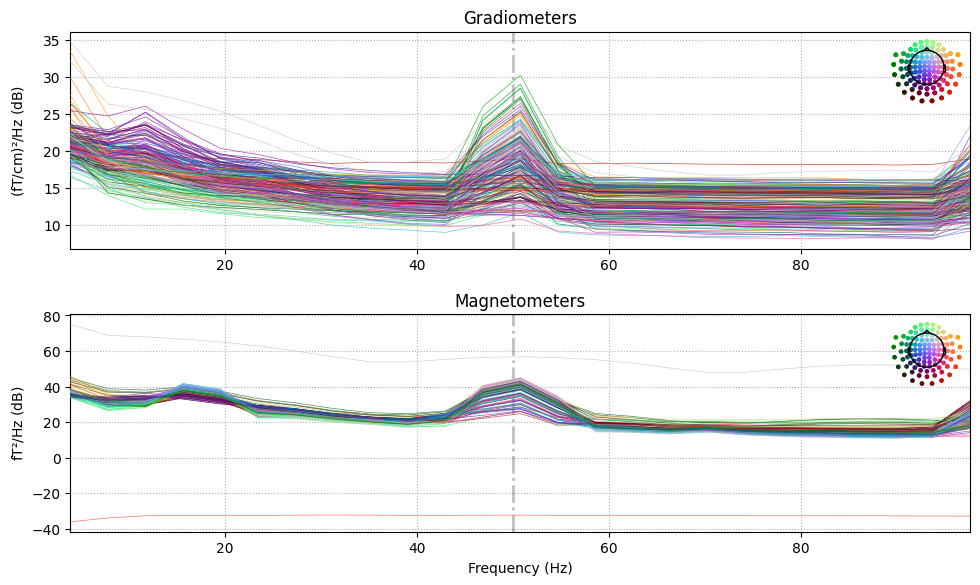

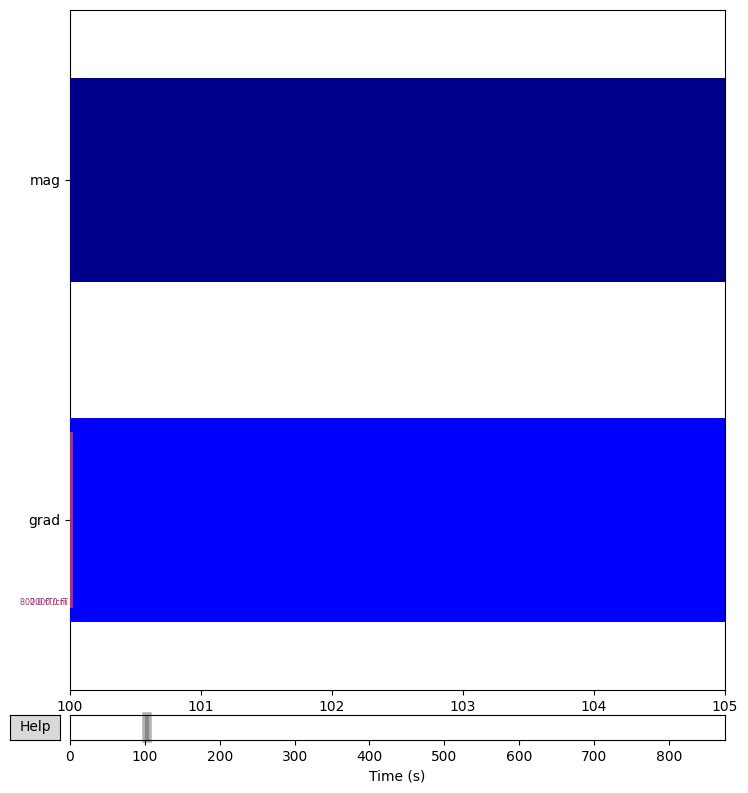

Effective window size : 0.256 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [24]:
fig = raw_sss.copy().pick(['meg']).plot(duration=5,
                                        start=100,
                                        butterfly=True)
fig1 = raw_sss.compute_psd(picks = ['meg'],fmin = 1,fmax = 100).plot()

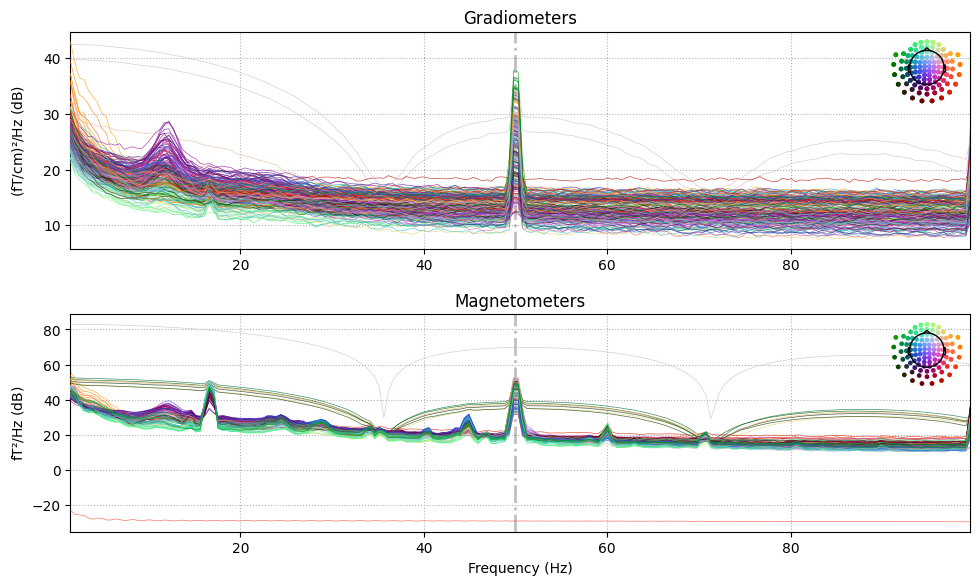

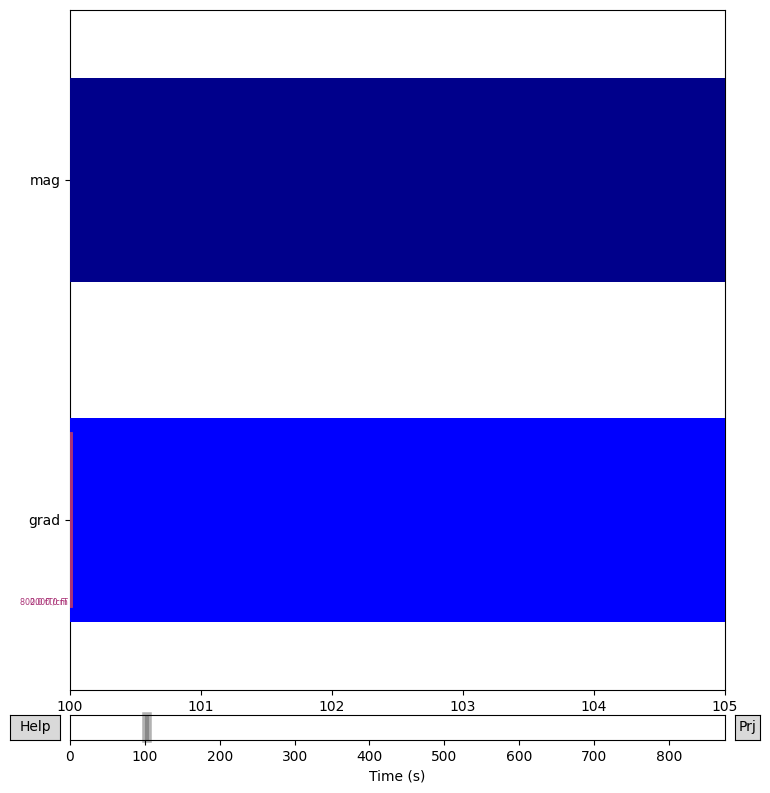

Effective window size : 0.256 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [23]:
fig = raw.copy().pick(['meg']).plot(duration=5,
                                    start=100,
                                    butterfly=True)
plt.close()
fig1 = raw.compute_psd(picks = ['meg'],fmin = 1,fmax = 100).plot()

In [27]:
method = 'sss'
file_name = 'mg99a01'
out_path = 'D:\projects\WM_GRID\DATA\mg99a_out'
fname_out = op.join(out_path,
                    file_name + '_' + method + '.fif')
raw_sss.save(fname_out, overwrite=True)

Writing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_sss.fif


C:\Users\qiaol\AppData\Local\Temp\ipykernel_24652\1427141690.py:6: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_sss.fif
[done]
